In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# surpress warnings
import warnings
warnings.filterwarnings('ignore')

# Topics in the #BTW17 Dataset
On this page, we want to illustrate some structures of the dataset regarding the underlying topics of the tweets as well as the Hashtag usage in general.

## Hashtag Analysis

To give a short overview over the dominating Hashtags in the dataset, we plotted the Top 5 Hashtags by total usage as well as by usage over time.

In [34]:
hashtags = pd.read_json('../data/hashtags_count.json')

In [18]:
def plot_top_hashtags(df: pd.DataFrame, n: int):
    """Plots top n hashtags from df

    Args:
        df (pd.DataFrame): Dataframe with hashtag count.
        n (int): Number of top hashtags to plot
    """
    topn = df[['hashtag','count']].groupby('hashtag', as_index=False).sum('count').nlargest(columns='count', n=n)
    df_plot = df[df['hashtag'].isin(topn['hashtag'])]
    df_plot.rename(columns={'hashtag':'Hashtag', 'count':'Frequency', 'date':'Date'}, inplace=True)
    
    df_plot_agg = df_plot.groupby('Hashtag', as_index=False).sum('Frequency').nlargest(columns='Frequency', n=n).sort_values(by='Frequency')
    
    figures = [
        px.bar(df_plot_agg, x='Frequency', y='Hashtag',# color='Hashtag',
               template='simple_white', color_discrete_sequence=px.colors.qualitative.T10),
        px.line(df_plot, x='Date', y='Frequency', color='Hashtag', 
                template='simple_white', color_discrete_sequence=px.colors.qualitative.T10)        
    ]
    
    fig = make_subplots(rows=1, cols=2)
    for i, figure in enumerate(figures):
        for trace in range(len(figure['data'])):
            fig.append_trace(figure['data'][trace], row=1, col=i+1)
    
    fig.update_layout(template='simple_white', width=1200, height=600)
    fig.show()

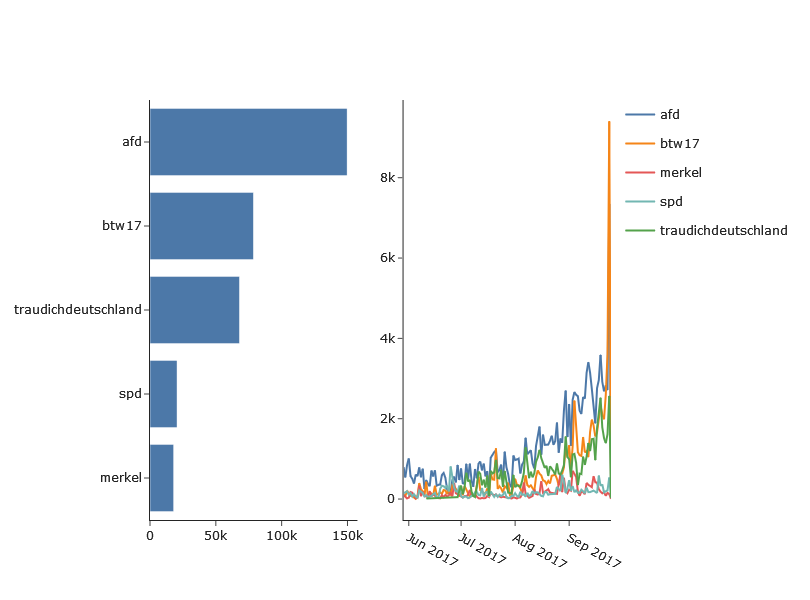

In [19]:
plot_top_hashtags(hashtags, 5)

In [5]:
def plot_hashtags_zipf_distribution(df: pd.DataFrame, n: int):
    """Plots top n hashtags from df with by zipf's law.

    Args:
        df (pd.DataFrame): Dataframe with hashtag count.
        n (int): Number of top hashtags to plot
    """
    df_plot = df[['hashtag','count']].groupby('hashtag', as_index=False).sum('count').nlargest(columns='count', n=n).reset_index(drop=True)
    df_plot["Frequency by Zipf's Law"] = 1
    df_plot['Rank'] = df_plot.index.values + 1
    for i in range(len(df_plot)):
        df_plot["Frequency by Zipf's Law"][i] = 1/df_plot['Rank'][i]
    
    df_plot['Actual Frequency normalized'] = (df_plot['count']-df_plot['count'].min())/(df_plot['count'].max()-df_plot['count'].min())
    df_plot.rename(columns={'hashtag':'Hashtag', 'count':'Actual Frequency'}, inplace=True)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_plot['Rank'], y=df_plot['Actual Frequency normalized'],
                             mode='lines', line=dict(color=px.colors.qualitative.T10[0], width=3),
                             name='Actual Frequency normalized'))
    fig.add_trace(go.Scatter(x=df_plot['Rank'], y=df_plot["Frequency by Zipf's Law"],
                             mode='lines', line=dict(color=px.colors.qualitative.T10[1]),
                             name="Frequency by Zipf's Law"))
    fig.update_layout(template='simple_white', width=800, height=600,
                      xaxis_title='Hashtag Rank', yaxis_title='Frequency')
    fig.show()

### Hashtag Distribution and Zipf's Law

Looking at the hashtags and their total usage, we find a distribution by *Zipf's Law*. *Zipf's Law* is well known in linguistics and describes the following. Let $e \in E$ be an element and $p$ be the probability of the appearance of this element $e$. Ordering the elements in $E$ by frequency, $p$ is inversely proportional to the rank $n$ of the element $e$:
$$p(n)\sim\frac{1}{n}$$
(Source: https://de.wikipedia.org/wiki/Zipfsches_Gesetz)

In our case, this means that we have few hashtags which were used very often, e.g. *#afd*, *#btw17*, *#spd*, while most of the hashtags were used only little. You can see this looking at the below plot of the frequency of the top 500 hashtags.

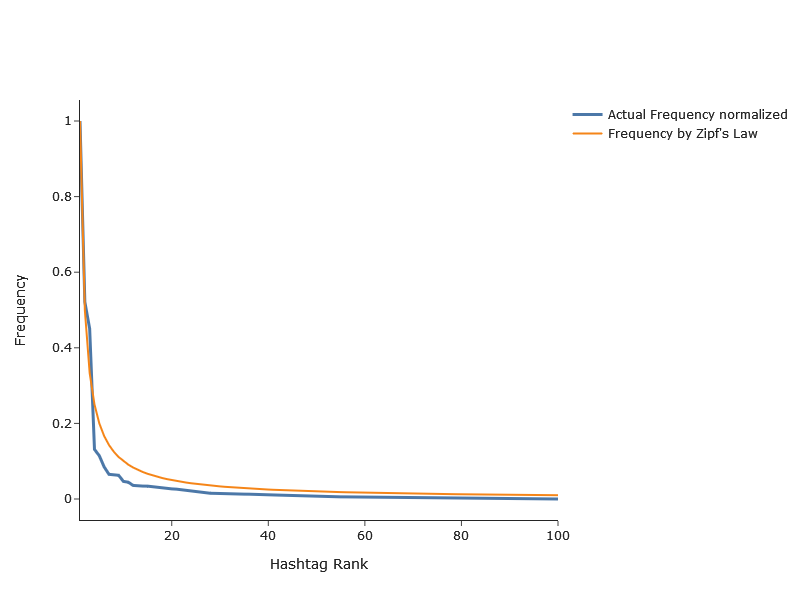

In [6]:
plot_hashtags_zipf_distribution(hashtags, 100)

### Party specific Hashtags

After the general distribution of the used Hashtags has been looked into, we will now concentrate on party specific hashtags, starting with the hashtags of every party in the german paliarment after the election 2017. These include the following parties and their hashtags (note only hashtags out of the top 100 hashtags were included):
- Alternative für Deutschland | *AfD* (#afd)
- Christlich Demokratische Union Deutschlands und Christlich Soziale Union in Bayern | *Union* (#cdu, #csu)
- Die Linke | *Die Linke* (#dielinke)
- Freie Demokratische Partei | *FDP* (#fdp)
- Bündnis 90/Die Grünen | *Die Grünen* (#gruene, #grüne, #grünen)
- Sozialdemokratische Partei Deutschlands | *SPD* (#spd)

Find in italic the names of the parties used from now on.

In [7]:
def plot_hashtags(df: pd.DataFrame, tags: int, party_tags=False):
    """Plots hashtags from df

    Args:
        df (pd.DataFrame): Dataframe with hashtag count.
        tags (int): Hashtags to include.
        party_tags (Boolean): Checks if tags are party hashtags.
    """
    df_plot = df[df['hashtag'].isin(tags)]
    
    # special case party tags
    if party_tags:
        df_plot.replace(to_replace={'afd': 'AfD',
                                    'cdu': 'Union', 'csu': 'Union',
                                    'dielinke': 'Die Linke',
                                    'fdp': 'FDP',
                                    'gruene': 'Die Grünen', 'grüne': 'Die Grünen', 'grünen': 'Die Grünen',
                                    'spd': 'SPD'},
                       inplace=True)
    
        df_plot.rename(columns={'hashtag':'Party', 'count':'Frequency', 'date':'Date'}, inplace=True)
        df_plot_agg = df_plot.groupby('Party', as_index=False).sum('Frequency').sort_values(by='Frequency')
        
        figures = [
            px.bar(df_plot_agg, x='Frequency', y='Party',# color='Hashtag',
                   template='simple_white', color_discrete_sequence=px.colors.qualitative.T10),
            px.line(df_plot, x='Date', y='Frequency', color='Party', 
                    template='simple_white', color_discrete_sequence=px.colors.qualitative.T10)        
        ]
        
    else:
        df_plot.rename(columns={'hashtag':'Hashtag', 'count':'Frequency', 'date':'Date'}, inplace=True)
        df_plot_agg = df_plot.groupby('Hashtag', as_index=False).sum('Frequency').sort_values(by='Frequency')
    
        figures = [
            px.bar(df_plot_agg, x='Frequency', y='Hashtag',# color='Hashtag',
                   template='simple_white', color_discrete_sequence=px.colors.qualitative.T10),
            px.line(df_plot, x='Date', y='Frequency', color='Hashtag', 
                    template='simple_white', color_discrete_sequence=px.colors.qualitative.T10)        
        ]
    
    fig = make_subplots(rows=1, cols=2)
    for i, figure in enumerate(figures):
        for trace in range(len(figure['data'])):
            fig.append_trace(figure['data'][trace], row=1, col=i+1)
    
    fig.update_layout(template='simple_white', width=1200, height=600)
    fig.show()

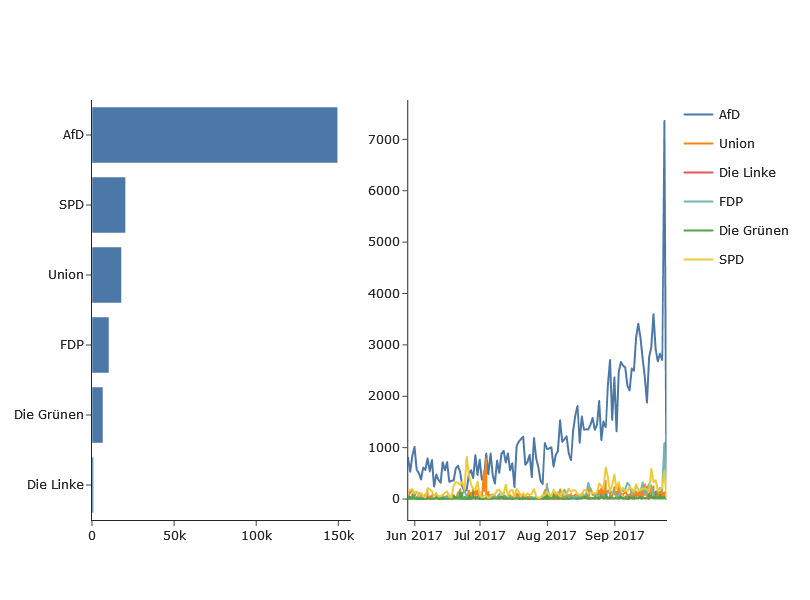

In [8]:
party_tags = ['afd', 'cdu', 'csu', 'dielinke', 'fdp', 'gruene', 'grüne', 'grünen', 'spd']
plot_hashtags(hashtags, tags=party_tags, party_tags=True)

During the election campaign, each party generated content and tried to tag every post with their respective campaign Hashtag. Note, that these Hashtags can differ from the party's slogan used during the election, as it is the case with *SPD*, *Die Grünen* and *Die Linke*. The used campaign Hashtags are the following:
- AfD: #traudichdeutschland
- Union: #fedidwgugl
- Die Linke: #lustauflinks
- FDP: #denkenwirneu
- Die Grünen: #darumgrün
- SPD: #zeitfuermartin

(Source: https://www.lilit-kommunikation.de/btw17-twitter-wahlkampf-140-zeichen-lilit/)

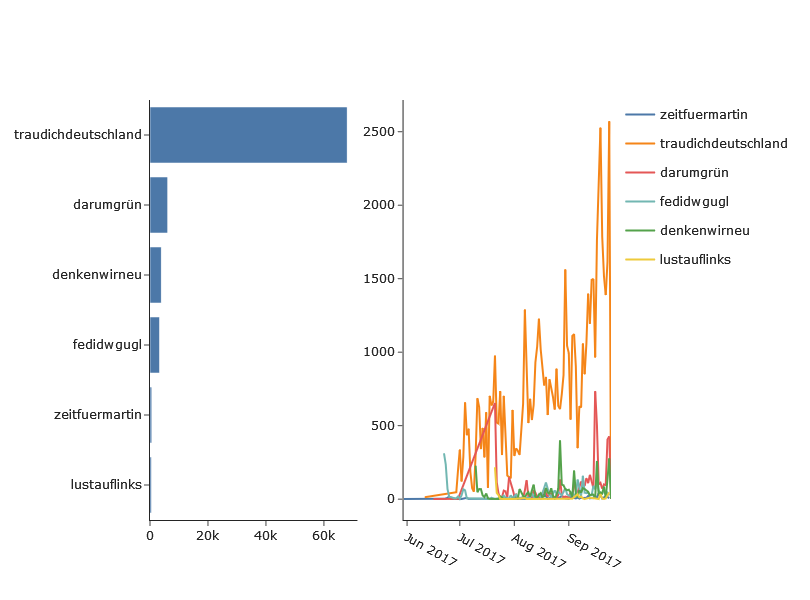

In [9]:
slogan_tags = ['traudichdeutschland', 'fedidwgugl', 'zeitfuermartin', 'denkenwirneu', 'darumgrün', 'lustauflinks']
plot_hashtags(hashtags, tags=slogan_tags, party_tags=False)

You see differences in the using of the campaign Hashtags for the different parties. Calculating the ratio of the campaign Hashtag to the Hashtag of the corresponding party, you get the following:

In [33]:
party_df = hashtags[hashtags['hashtag'].isin(party_tags)]
party_df.replace(to_replace={'afd': 'AfD',
                             'cdu': 'Union', 'csu': 'Union',
                             'dielinke': 'Die Linke',
                             'fdp': 'FDP',
                             'gruene': 'Die Grünen', 'grüne': 'Die Grünen', 'grünen': 'Die Grünen',
                             'spd': 'SPD'},
                       inplace=True)
party_df = party_df.groupby('hashtag', as_index=False).sum('count')
party_df.rename(columns={'hashtag': 'Party', 'count': 'Frequency Party Hashtag'},
                inplace=True)

slogan_df = hashtags[hashtags['hashtag'].isin(slogan_tags)]
slogan_df.replace(to_replace={'traudichdeutschland': 'AfD',
                              'fedidwgugl': 'Union',
                              'lustauflinks': 'Die Linke',
                              'denkenwirneu': 'FDP',
                              'darumgrün': 'Die Grünen',
                              'zeitfuermartin': 'SPD'},
                  inplace=True)
slogan_df = slogan_df.groupby('hashtag', as_index=False).sum('count')
slogan_df.rename(columns={'hashtag': 'Party', 'count': 'Frequency Slogan Hashtag'},
                 inplace=True)
    
ratio_df = party_df.merge(slogan_df, how='inner', on='Party')
ratio_df['Slogan to Party Ratio'] = round(ratio_df['Frequency Slogan Hashtag'] / ratio_df['Frequency Party Hashtag'], 3)
ratio_df

,Party,Frequency Party Hashtag,Frequency Slogan Hashtag,Slogan to Party Ratio
0,AfD,149696,67989,0.454
1,Die Grünen,6689,6099,0.912
2,Die Linke,1038,479,0.461
3,FDP,10341,3858,0.373
4,SPD,20525,624,0.030
5,Union,17996,3268,0.182


As we see, *Die Grünen* clearly has the best Slogan to Party Ratio. A reason for that **could** be, that *Die Grünen* mostly used their Hashtags themselves and therefore added the slogan Hashtag to the party Hashtag in most of the tweets. Of course, this is a these and would need some further research. Regarding the usage of their Hashtags in total, the Slogan to Party Ratio of the *AfD* has to be highlighted as well. Despite *#afd* being the most used Hashtag in the dataset (see above), in nearly half of the tweets, the slogan *#traudichdeutschland* was used as well, which makes it to one of the most used Hashtags in the dataset. What the *AfD* accomplished with this Hashtag, the *SPD* failed to do with their slogan. This could be an issue because of different used Hashtags during the campaign (see https://www.lilit-kommunikation.de/btw17-twitter-wahlkampf-140-zeichen-lilit/). This shows in the baddest Slogan to Party Ratio of all parties.

## Topic Analysis
Because a proper topic analysis with methods from Natural Language Processing would be both complicated on twitter data and out of scope of this project, we use a different measure *Tf-Idf* to weighten word n-grams which are popular in the dataset.  
### Tf-Idf
Tf-Idf is the combination of the two metrics **Term frequency (Tf)** and **Inverse document frequency (Idf)**. Tf describes the relative term frequency of term $t$ for a document $D$. In our case, terms are n-grams with $n \in {2,3}$ and every tweet is a document. To get this metric, we sum the frequency $f$ of a term $t$ in a document $D$ and divide through the sum of frequency, any terms $t'$ occures in the document $D$. With this, we get the Term frequency $$\text{Tf}(t, D)=\frac{f(t,D)}{\sum_{t'\in D}f(t',D)}$$

Meanwhile, the Inverse document frequency measures the information, which a word contains regarding not only one document, but the whole corpus. With $N$ being the number of documents (in our case tweets) in total and $\sum_{D:t\in D}1$ being the number of documents $D$ which contain term $t$, we can compute the Inverse document frequency $$\text{Idf}(t)=\log \frac{N}{\sum_{D:t\in D}1}$$

With this two metrics, we can compute **Tf-Idf** with $\text{Tf}(t,D) * \text{Idf}(t)$.

(Source: https://en.wikipedia.org/wiki/Tf%E2%80%93idf)